# Teil 2: Transformieren, Extrahieren und Visualisieren von Features
## Mit Polars und Seaborn

Seaborn bietet uns eine einfache Möglichkeit um Grafiken übersichtlich und visuell ansprechend aufzubereiten, ohne uns in den komplexen Einstellungsmöglichkeiten von matplotlib zu verlieren, auf welcher seaborn basiert.  

In [116]:

import numpy as np
import scipy as sp
import polars as pl
# not all libs can work with polars/arrow data yet so we may use pandas as a crutch for now
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import altair as alt
# backend zu seaborn - nur fuer feineinstellungen
import matplotlib.pyplot as plt
# apply default seaborn theme, scaling, and color palette
sns.set_theme()

Es gibt mehrere gute Visualisierungbibliotheken:

| **Name**        | **Typ**         | **Quelle**                                      | **Dim** | **Basiert auf** | **Beschreibung**                                                                                                                                                                 |
|-----------------|-----------------|-------------------------------------------------|---------|-----------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Matplotlib      | Bibliothek      | https://matplotlib.org/                         | 2D, 3D  | -               | Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python. Matplotlib makes easy things easy and hard things possible.       |
| Seaborn         | Bibliothek      | https://seaborn.pydata.org/                     | 2D      | Matplotlib      | Visuell ansprechende Plots über eine einfache, deklarative API. Wenn man das Styling über Themes hinaus anpasen will, muss man auf Matplotlib zugreifen                                                                                                                 |
| Altair          | Bibliothek      | https://altair-viz.github.io/gallery/index.html | 2D      | Vega/Vega-Lite (JS)            | Ähnlich einfach wie Seaborn, jedoch mit einer anderen API unn herangehensweise. Zusätzlich bietet es interaktive Features (Pan/Zoom/Tooltips) und es ist einfach das Styling anzupassen                                  |
| Plotnine        | Bibliothek      | https://plotnine.readthedocs.io/en/stable/      | 2D      | Matplotlib      | Ein Python Port von ggplot2, welches im R-Universum sehr beliebt ist. Die API basiert auf einer "Grammatik" für Grafiken und ist für Anfänger meist etwas schwerer zu verstehen. |
| Plotly          | Bibliothek      | https://github.com/plotly/plotly.py             | 2D, 3D  | plotly.js       | Interaktive HTML-Plots in 2D und 3D, die in einem Browser angezeigt werden können. Die API ist sehr umfangreich und bietet viele Möglichkeiten, mit den Plots zu interagieren.   |
| Apache Superset | Web-Applikation | https://github.com/apache/superset              | 2D, 3D  | -               | Eine freie Webanwendung zur interaktiven Datenexploration und Business-Intelligence welche mit vielen Datenquellen direkt umgehen kann.                                          |


Leider unterstuetzt kaum eine Bibliothek das neue Arrow-Format. Bei Seaborn geht es zu einem grossen Teil schon, fuer manche Funktionen wird aber immernoch eine Konvertierung in einen pandas.DataFrame benoetigt. Da Seaborn im Vergleich ein gutes Feature-Set hat, werden wir es fuer die Visualisierung verwenden.

In [118]:
# read in the previously created parquet file
df = pl.read_parquet("resources/data/gta_v/gta_v_data.parquet")
df.head()

title,vehicle_class,manufacturer,features,acquisition,price,storage_location,delivery_method,modifications,resale_flag,race_availability,based_on,seats,weight_in_kg,drive_train,gears,release_date,release_dlc,lap_time,bulletproof,weapon1_resistance,weapon2_resistance,weapon3_resistance,weapon4_resistance,weapon5_resistance,speed,acceleration,braking,handling,overall,vehicle_url,upgrade_cost,release_dlc_version,release_dlc_name,resale_price_base,resale_price_upgrade,top_speed_real_kmh,top_speed_in_game_kmh,model
str,str,str,str,str,f64,str,str,str,str,str,str,i64,f64,str,str,date,str,duration[ns],str,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,str,f64,f64,str,f64,f64,f64,f64,str
"""Volatol""","""Planes""","""NA""","""Armored Vehicl...","""Warstock Cache...",3.724e6,"""Hangar (Person...","""Interaction Me...","""Hangar Aircraf...","""Can be sold on...","""Transform Race...","""Avro Vulcan, M...",4,40000.0,"""NA""","""NA""",2017-12-12,"""1.42 The Dooms...",53s 501ms,"""Bulletproof fr...",3,1,2,1,1,76.07,28.58,32.5,1.01,34.54,"""https://www.gt...",374150.0,1.42,"""The Doomsday H...",2.2344e6,2.421475e6,266.35,250.0,"""Volatol"""
"""Sadler""","""Utility""","""Vapid""","""Has Variants, ...","""Can be stolen""",35000.0,"""Garage (Person...","""Mechanic""","""Los Santos Cus...","""Can be sold if...","""Can be used in...","""First Generati...",4,2100.0,"""NA""","""5""",2013-09-17,"""1.01 Game Laun...",1m 19s 113ms,"""No""",1,1,2,1,1,69.75,50.0,20.0,62.12,50.47,"""https://www.gt...",176750.0,1.01,"""Game Launch""",21000.0,109375.0,160.93,130.0,"""Sadler"""
"""Benefactor Ter...","""Commercial""","""Benefactor""","""Armored Vehicl...","""Warstock Cache...",1.375e6,"""Nightclub Ware...","""Interaction Me...","""Point of Stora...","""Cannot be sold...","""Cannot be used...","""Mercedes-Benz ...",4,10000.0,"""RWD""","""6""",2018-08-14,"""1.44 After Hou...",1m 28s 302ms,"""Bullet resista...",34,34,81,17,8,64.39,40.0,8.33,59.09,42.95,"""https://www.gt...",256000.0,1.44,"""After Hours""",0.0,0.0,140.41,120.0,"""Terrorbyte"""
"""Mammoth Dodo""","""Planes""","""Mammoth""","""Armored Vehicl...","""Elitás Travel""",500000.0,"""Pegasus Vehicl...","""Pegasus Concie...","""Paint Job Only...","""Cannot be sold...","""Transform Race...","""De Havilland C...",4,2000.0,"""RWD""","""NA""",2014-11-18,"""1.18 PS4 & Xbo...",55s 335ms,"""Bulletproof fr...",2,1,2,1,1,76.07,25.0,18.99,25.95,36.5,"""https://www.gt...",0.0,1.18,"""PS4 & Xbox One...",0.0,0.0,216.05,250.0,"""Dodo"""
"""Fathom FQ 2""","""SUVs""","""Fathom""","""Mystery Prize""","""Can be stolen""",50000.0,"""Garage (Person...","""Mechanic""","""Los Santos Cus...","""Can be sold if...","""Can be used in...","""Infiniti QX70""",4,2400.0,"""NA""","""5""",2013-09-17,"""1.01 Game Laun...",1m 18s 880ms,"""No""",1,1,2,1,1,72.43,45.0,8.33,60.61,46.59,"""https://www.gt...",132200.0,1.01,"""Game Launch""",30000.0,96100.0,167.37,135.0,"""FQ 2"""


# Neues Feature (Spalte): Anzahl an Fahrzeug-Features 
Bei Listen ist es etwas schwieriger, da die Spalten nicht einfach so aufgeteilt werden können, ohne die Gesamtanzahl stark zu erhöhen.
Wir erstellen _eine_ neue Spalte, welche nur die Anzahl der Features enthält (diese sind getrennt durch Kommata).
Damit können wir zwar nicht zwischen den Features unterscheiden, aber wir können zumindest statistisch Tendenzen feststellen.


In [119]:

df = df.with_columns(
        pl.col('features').str.split(',').arr.lengths().alias('feature_count'),
        # alternative mit apply einer python lambda funktion (langsamer)
        # pl.col("features").str.split(',').apply(lambda x: len(x)).alias("feature_count"),
) 

df.get_column('feature_count')

feature_count
u32
8
3
9
7
1
3
4
2
2


## Neues Feature: Angepasste Upgraded-Resale Kosten  
Wir koennen jetzt schauen, ob es Fahrzeuge gibt, die mit allen Upgrades teurer verkauft werden koennen, als die Summe von Price und Upgrade-Kosten (was in der echten Welt nicht passieren sollte).

In [120]:
df = df.with_columns(
    (pl.col('resale_price_upgrade') - pl.col('upgrade_cost')).alias('resale_price_upgrade_adjusted'),
)

df= df.with_columns(
    (pl.col('resale_price_upgrade_adjusted') / pl.col('price')).alias('resale_price_upgrade_adjusted_ratio'),
)
# check instances of profitable vehicles
df.filter(
    (pl.col('resale_price_upgrade_adjusted') > 0.0) & (pl.col('resale_price_upgrade_adjusted_ratio') > 1.0)
).shape

(0, 42)

> Wie wir sehen, gibt es keine Fahrzeuge, die mit Profit verkauft werden koennen. Die Oekonomie im Spiel scheint also gut entworfen zu sein. 

# Visualisieren der Features mit Seaborn
Jetzt koennen wir damit beginnen uns mit den Daten vertraut zu machen. Dazu erzeugen wir Grafiken der um die Abhaengigkeiten zw. den einzelnen Features zu erkennen.
Es gibt verschiedenste Arten von Grafiken, die wir verwenden koennen. Wir werden uns hier auf die folgenden beschränken:
- Histogramme
- Boxplots
- Scatterplots
- Heatmaps
- Pairplots  

Ein ganz einfaches Beispiel um den Zusammenhang zweier Variablen zu erkennen ist ein Scatterplot. Dabei werden zwei Variablen als 2D Punkt mit (x,y)-Koordinaten dargestellt.

Wir koennen z.b. Das Vehikelgewicht mit dem Top Speed vergleichen.


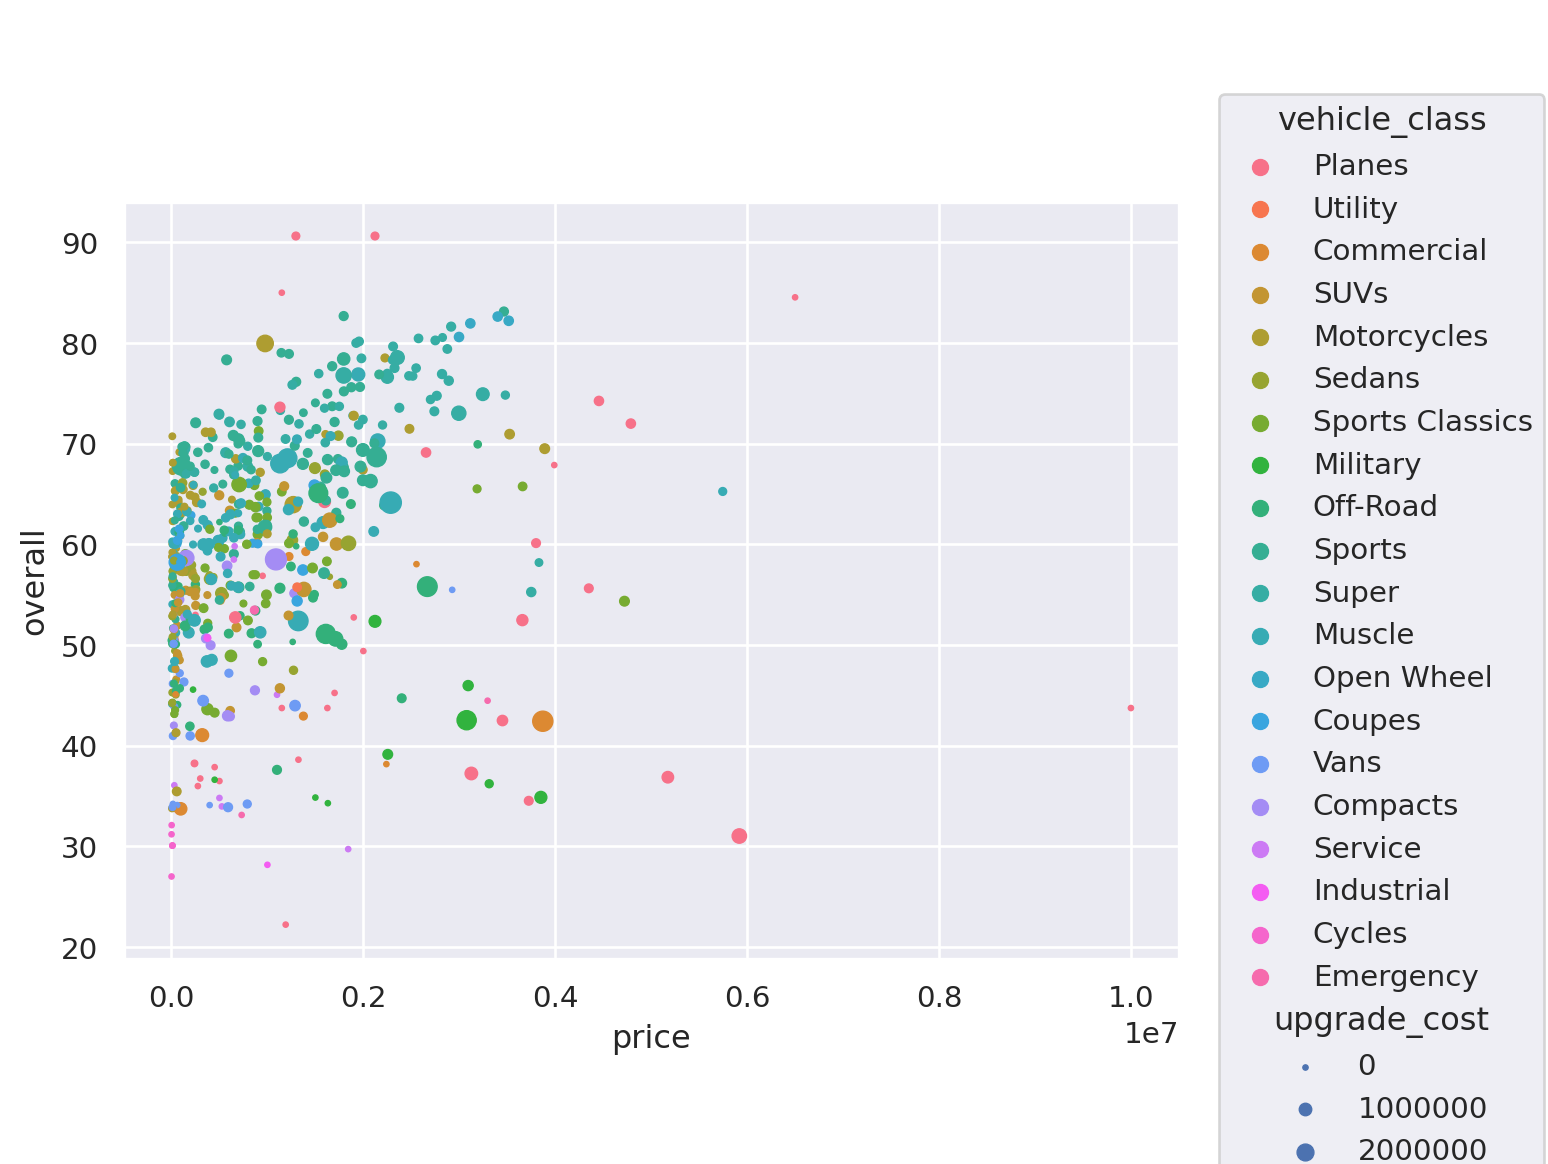

In [121]:
# "alte" api
# sns.scatterplot(x="price", y="overall", data=df, hue='vehicle_class')

# neue objects api
# https://seaborn.pydata.org/tutorial/objects_interface.html
(
    so.Plot(
        data=df, 
        x="price", 
        y="overall", 
        color='vehicle_class', 
        pointsize="upgrade_cost",
    )
    #.facet('feature_count')
    .add(so.Dot())
)   


Dieser Plot ist noch recht unuebersichtlich, da wir viele Ausreisser haben die einen klaren Zusammenhang verdecken. 
In unserem Fall haben wir auch z.B FLugzeuge unter den Fahrzeugklassen, was das Bild verfaelscht. 


In [122]:
print(df.get_column('vehicle_class').unique())

shape: (20,)
Series: 'vehicle_class' [str]
[
	"Open Wheel"
	"SUVs"
	"Commercial"
	"Muscle"
	"Military"
	"Service"
	"Coupes"
	"Industrial"
	"Super"
	"Compacts"
	"Planes"
	"Sedans"
	"Sports Classic...
	"Sports"
	"Cycles"
	"Emergency"
	"Vans"
	"Motorcycles"
	"Utility"
	"Off-Road"
]


Hier waere es wohl sinnvoll, mindestens `Planes`, `Cycles` und `Industrial` auszusortieren, um nicht Äpfel mit Birnen zu vergleichen.

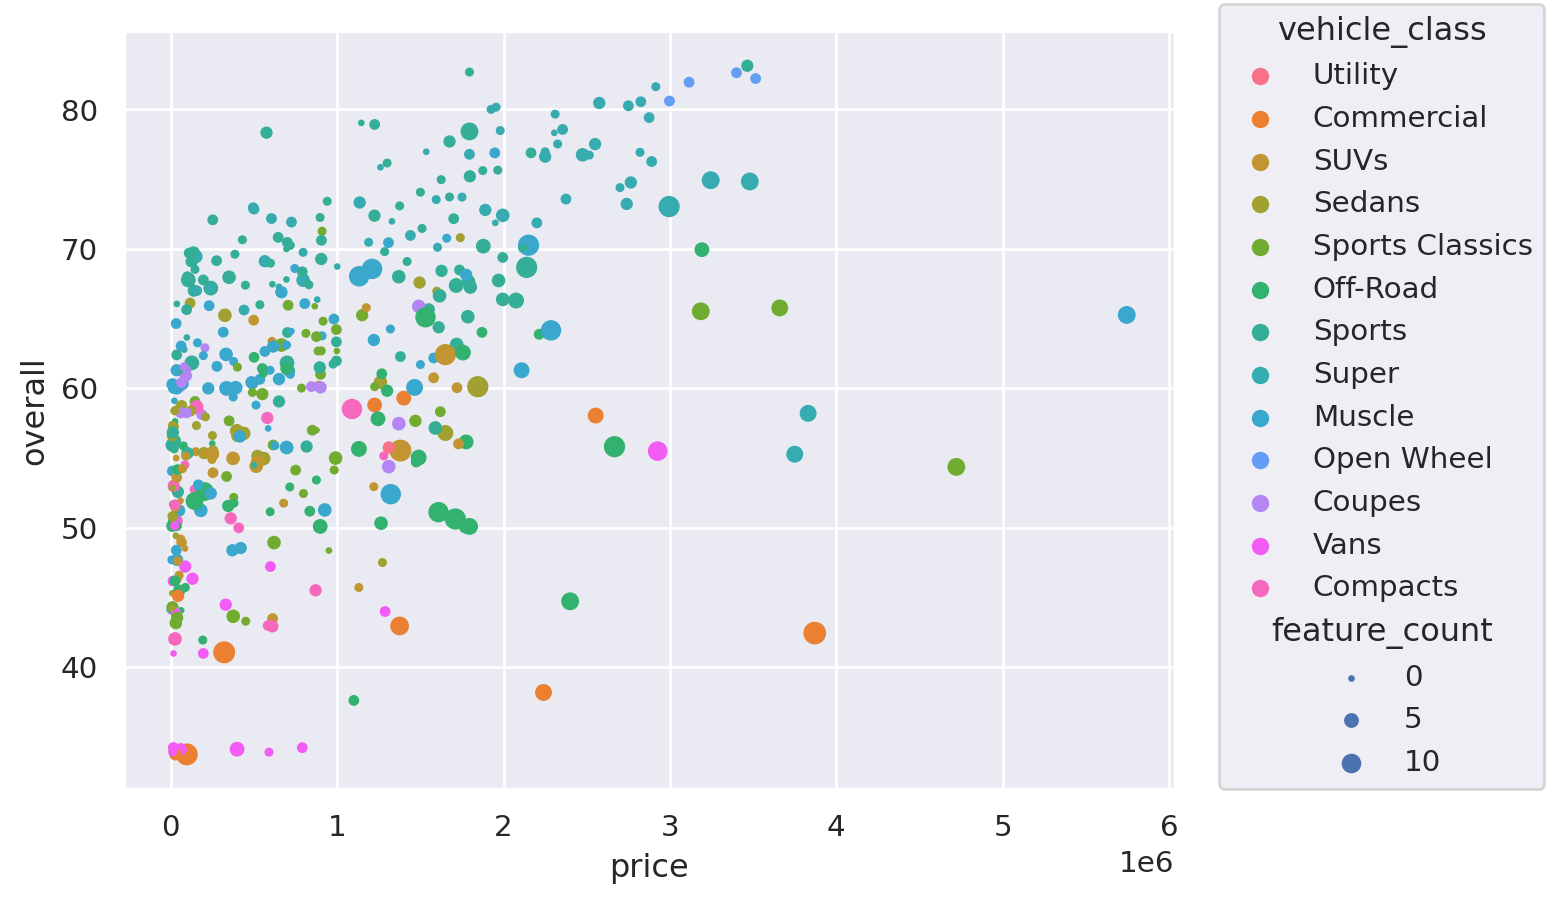

In [123]:
exclass = ['Planes', 'Cycles', 'Industrial', 'Emergency', 'Military', 'Motorcycles', 'Service']

dfv = df.filter(
        pl.col('vehicle_class').is_in(exclass).is_not()
)

(
    so.Plot(
        data=dfv, 
        x="price", 
        y="overall", 
        color='vehicle_class', 
        pointsize="feature_count",
    )
    .add(so.Dot())
)   

## Overall Scores pro Fahrzeugklasse

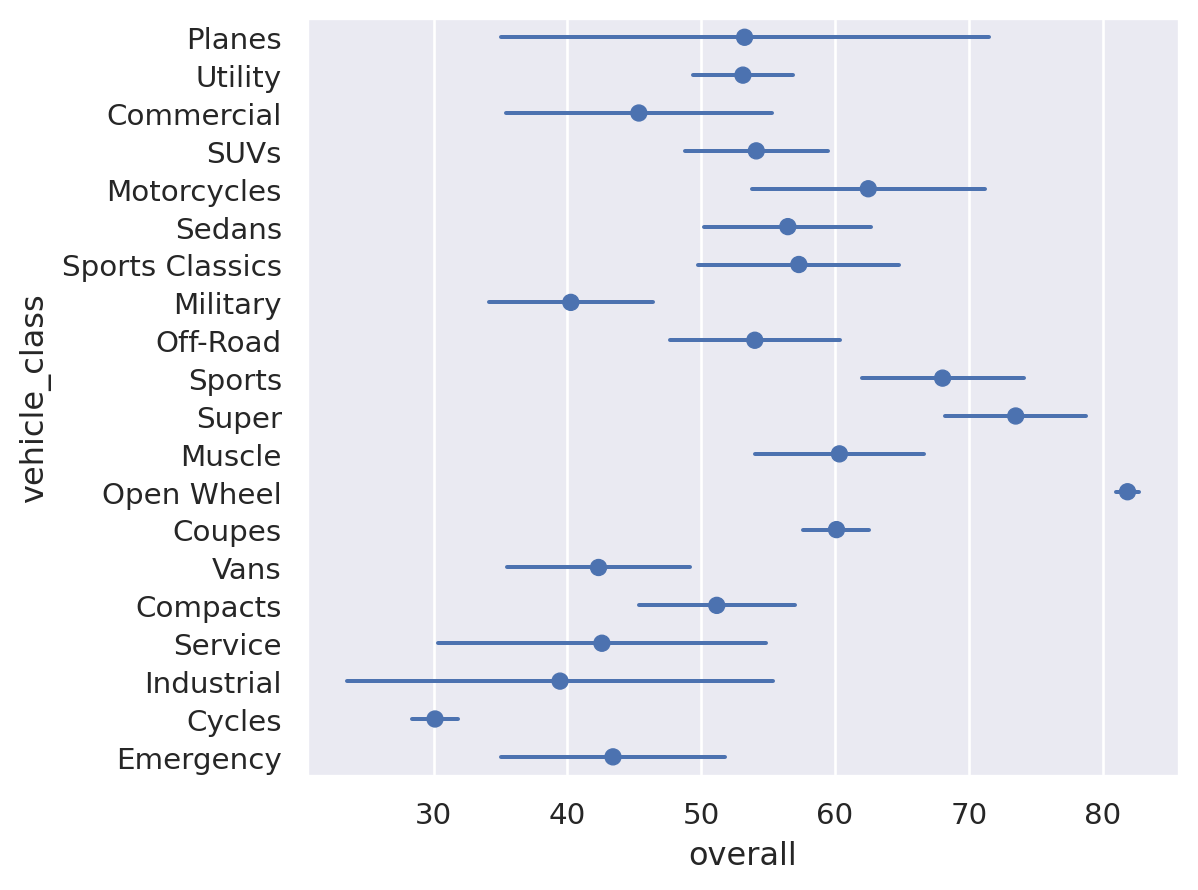

In [124]:
( 
    so.Plot(
        data=df, 
        x='overall',
        y='vehicle_class',
    )
    .add(so.Dot(), so.Agg(), so.Dodge())
    .add(so.Range(), so.Est(errorbar='sd'), so.Dodge())
)

## Pairplots zwischen mehreren Variablen
### Fahreigenschaften visualisieren

shape: (567, 1)
┌──────────────┐
│ weight_in_kg │
│ ---          │
│ f64          │
╞══════════════╡
│ 40000.0      │
│ 2100.0       │
│ 10000.0      │
│ 2000.0       │
│ ...          │
│ 1175.0       │
│ 1600.0       │
│ 1400.0       │
│ 2300.0       │
└──────────────┘


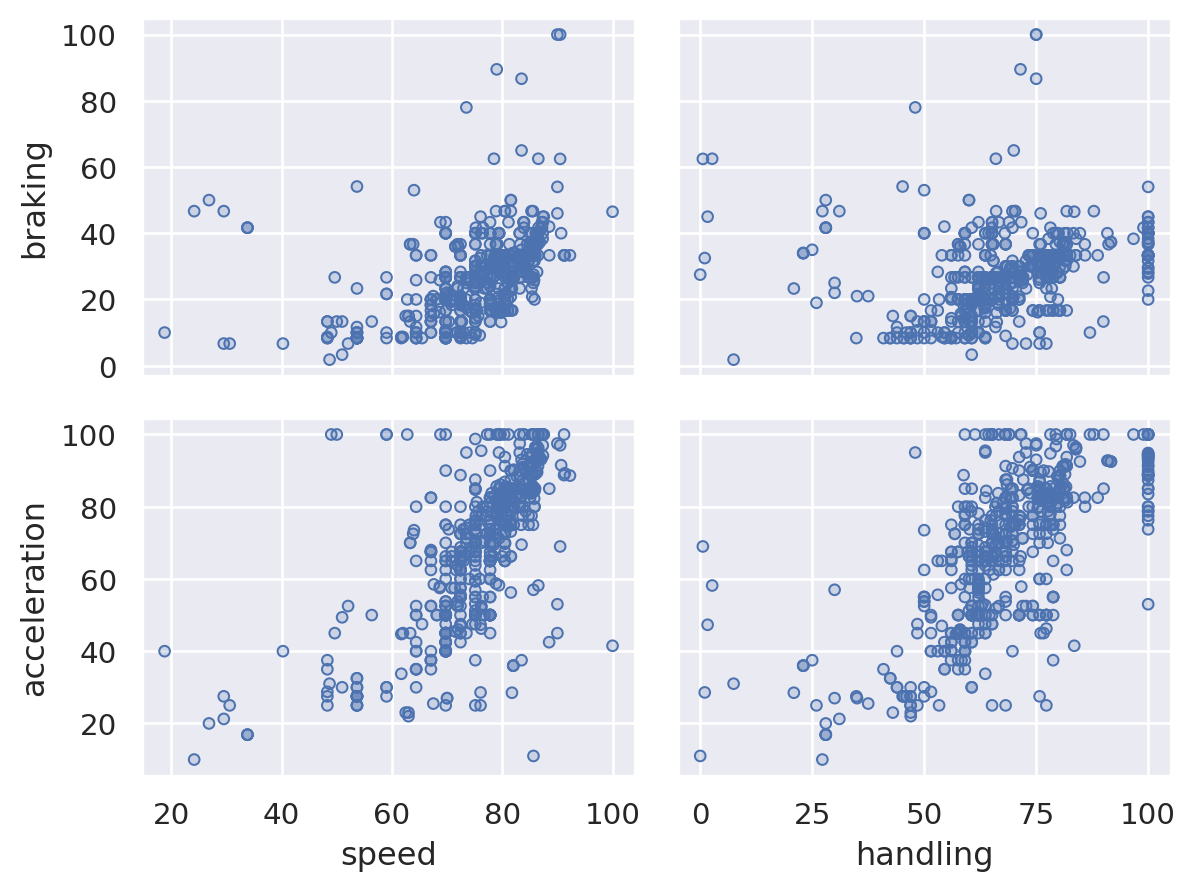

In [135]:
# this function need to_pandas() to work (for now)
print(df.select('weight_in_kg'))
(
    so.Plot(df.to_pandas())
    .pair(x=["speed", "handling"], y=["braking", "acceleration"])
    .add(so.Dots())
)

# Interaktives Visualisieren mit Altair 

In [ ]:
# TODO altair doesn't work with durations, convert to integer nanoseconds 
# altair also doesn't support polars directly, so we convert to_pandas()
dfp = dfv.select(
        pl.exclude(['lap_time', 'release_date'])
).to_pandas()


alt.Chart(dfp).mark_circle(size=60).encode(
    x='price',
    y='overall',
    color='vehicle_class',
    tooltip=['title', 'vehicle_class', 'weight_in_kg', 'top_speed_in_game_kmh', 'price', 'based_on']
).interactive()

/home/dp/source/workshop-kmu-data/env/lib64/python3.11/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)